## 1 Introduction

I will be using the Northwind Traders Access database to perform a hypothesis test to answer the following question.<br>
**_Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?_**<br> 
A complete blogpost about the project can be found by following this [link](https://medium.com/@trvlingteacher/hypothesis-testing-9d1fdf28e232)

Followed by at least 3 additional hypothesis tests.  <br>

**Synopsis of Dataset**<br>
"The Northwind database is a sample database used by Microsoft to demonstrate the features of some of its products, including SQL Server and Microsoft Access. The database contains the sales data for Northwind Traders, a fictitious specialty foods export/import company." 
<br>

**Null Hypothesis** <br>
The number of products customers order is not related to the level of discount <br>

**Alternative Hypothesis** <br>
The number of products customers order is related to the level of discount.<br>

**Effect Size**<br>
Numbers of products ordered at the 5%,15%,20%,25% levels of discount. 

**Variables We Are Interested in Determining the Relationship Between**<br>
Number of products ordered and percent discount<br>

### 1.1 Loading Libraries

In [2]:
# add every library I will use throughout the project here
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stat
from scipy import stats
from __future__ import print_function

import scipy.stats as stats
#data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

#for t-tests
from scipy.stats import ttest_ind

#for ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

### 1.2 Retrieve data from database

In [3]:
# create a connection to the database
conn = sqlite3.connect('Northwind_small.sqlite', detect_types=sqlite3.PARSE_COLNAMES)
c = conn.cursor()

# query the database
c.execute("SELECT * FROM OrderDetail;")

# store results in a dataframe
df_orders = pd.DataFrame(c.fetchall())
df_orders.columns = [i[0] for i in c.description]

# double check everything imported correctly
df_orders.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


By looking at the provided schema I was able to locate the table of interest and save the relevant data within a Pandas dataframe for further analysis.  The **orders** table contains information with the variables of interest: **Discount** and **Quantity**. 

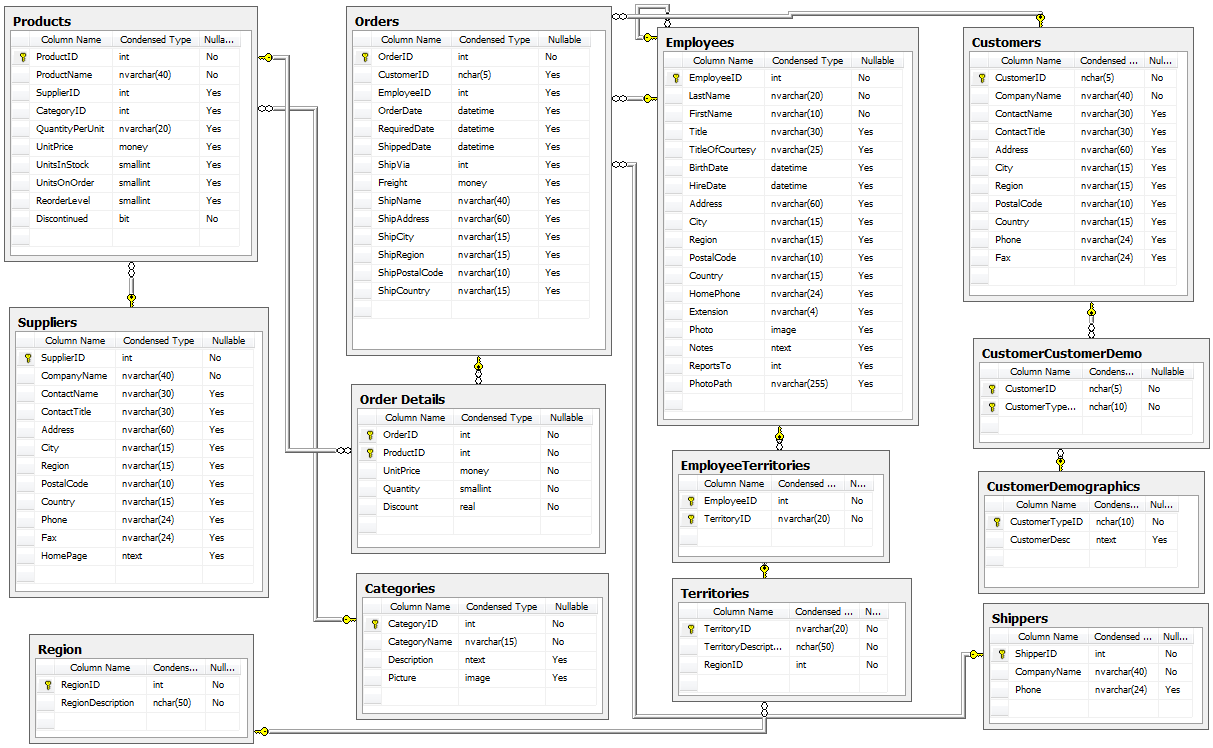

In [4]:
from IPython.display import Image
Image("Northwind_ERD.png")

### 1.3 Data structure and content

In [5]:
df_orders.isna().sum()

Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

No null values that need to be cleaned.

In [6]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In total, there are 6 variables and 2155 entries.

In [7]:
df_orders.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [8]:
df_orders = df_orders.drop(df_orders[(df_orders.Discount > 0) & (df_orders.Discount < 0.05)].index)
df_orders = df_orders.drop(df_orders[(df_orders.Discount == 0.06)].index)

In [9]:
df_orders.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 ])

**OrderID** is simply an index so the values are insignificant as long as there are no duplicates.<br>

**ProductId** contains 1 value for each order.  Therefore, I am making the assumption that each order contains only 1 type of product. <br>

**UnitPrice** ranges from 2 to 263.50 I may take this number multiply it by the quantity and apply the discount to create a column for total sale for another hypothesis test.  <br>

**Quantity** is one of the features we are directly interested in, the values are all whole number integers between 1 and 130. <br>

**Discount** is the other variable we are directly interested in and the range is 0-%25.<br>

**Let's Take a Look at the Distributions of or Variables of Interest**<br>

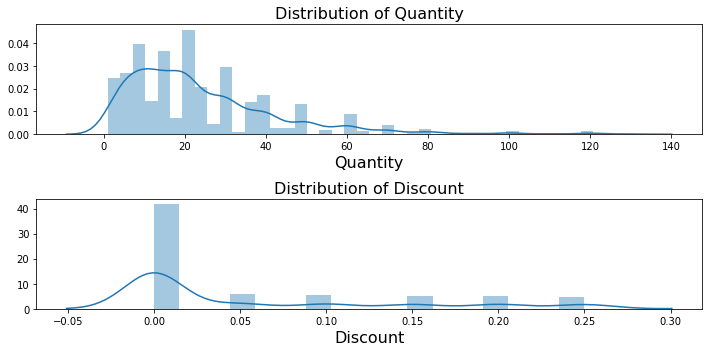

In [53]:
import warnings
warnings.filterwarnings("ignore")
#dist plot of Quantity values
x = plt.figure(figsize=(10,5))
plt.subplot(211)

sns.distplot(df_orders['Quantity'], hist='density')
plt.title('Distribution of Quantity', fontsize=16)
plt.xlabel('Quantity', fontsize=16)

#dist plot of discount values
plt.subplot(212)

sns.distplot(df_orders['Discount'], hist='density')
plt.title('Distribution of Discount', fontsize=16)
plt.xlabel('Discount', fontsize=16)

plt.tight_layout()
plt.show()
x.savefig("distribution.png", bbox_inches='tight')

The **Dependent Variable - Quantity** is positively skewed with a minimum order quantity of 1 and the largest order was 130.  Meaning that most orders include only a few items.  <br>

This imaginary business would likely be intersted in an increase of the quantity of items sold per each order placed.  Somebody had the idea that the level of discount offered is directly related to the quantity of items a customer orders.  Therefore our **Independent Variable-Discount** is shown above.<br>

We can immediately see that most orders have no discount and the largest discount offered is 25%. <br>
**Discount** is an **ordinal variable/feature** that has a very near, but not quite, **uniform distribution** across the 5%, 10%, 15%, 20%, 25% increments.

**In order to select the most appropriate statistical test, a researcher should answer the following six questions.**<br>

1) How many variables will we be tracking?<br>
**2 variables, both are currently assumed to be independent our hypothesis test is interested in discovering a relationship between the IV - Discount and DV - Quantity** br  
2) At what level of measurement is the independent variable?<br>
**ordinal- the percentages are discrete yet in rank order**<br>
3) What is the level of measurement of the dependent variable?<br>
**continuous integers**
4) Are the observations independent or dependent?<br>
**We are given no information about how the discount level is chosen when a sale is made.  Therefore, it is assumed that these 2 features are independent**
5) Do the comparisons involve populations to populations, a sample to a population, or are two or more samples compared?<br> 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3105563/ read this when I have time
**I will be creating samples from 
6) Is the hypothesis being tested comparative or relationship?<br>


## 2 Experiment Design

### 2.1 Setting up control and experimental groups

**_Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?_** <br>

- The **control** group is comprised of orders that did not receive a discount<br>
- The **experimental** group is comprised of orders that did receive a discount<br>


In [12]:
# create control and experimental groups
# put items without the variable we are curious about into control group
control = df_orders[df_orders['Discount'] == 0]
ctrl = control['Quantity']

# put items with the variable we are curious about into experimental group
experimental = df_orders[df_orders['Discount'] != 0]
exp= experimental["Quantity"]

In [13]:
control.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [14]:
ctrl.head()

0    12
1    10
2     5
3     9
4    40
Name: Quantity, dtype: int64

In [15]:
experimental.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05
11,10252/20,10252,20,64.8,40,0.05


### 2.2 Checking Assumptions

#### 2.2.1 Normality


In order to perform a two-sample t-test, there are several assumptions that need to be met, the first of which is normality. We will assess this visually and also perform a normality test using the [normaltest function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#scipy.stats.normaltest) which combines measures of skew and kurtosis.

Control


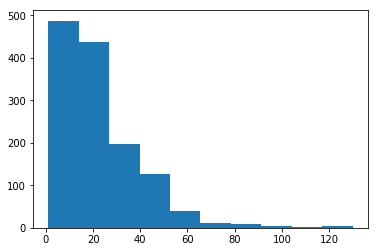

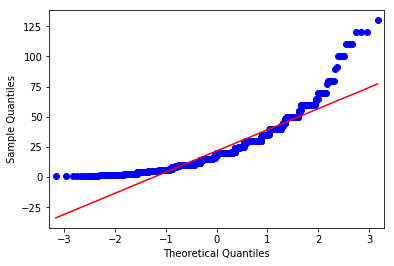

Experimental


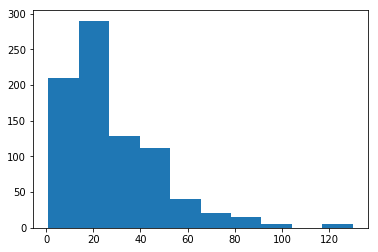

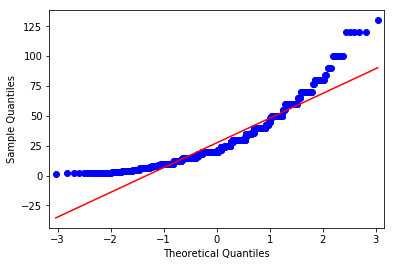

In [56]:
labels = ['Control','Experimental']
for ind, i in enumerate([ctrl, exp]):
    print (labels[ind])
    plt.hist(i)
    sm.qqplot(i, line='s')
    
    
    plt.show()


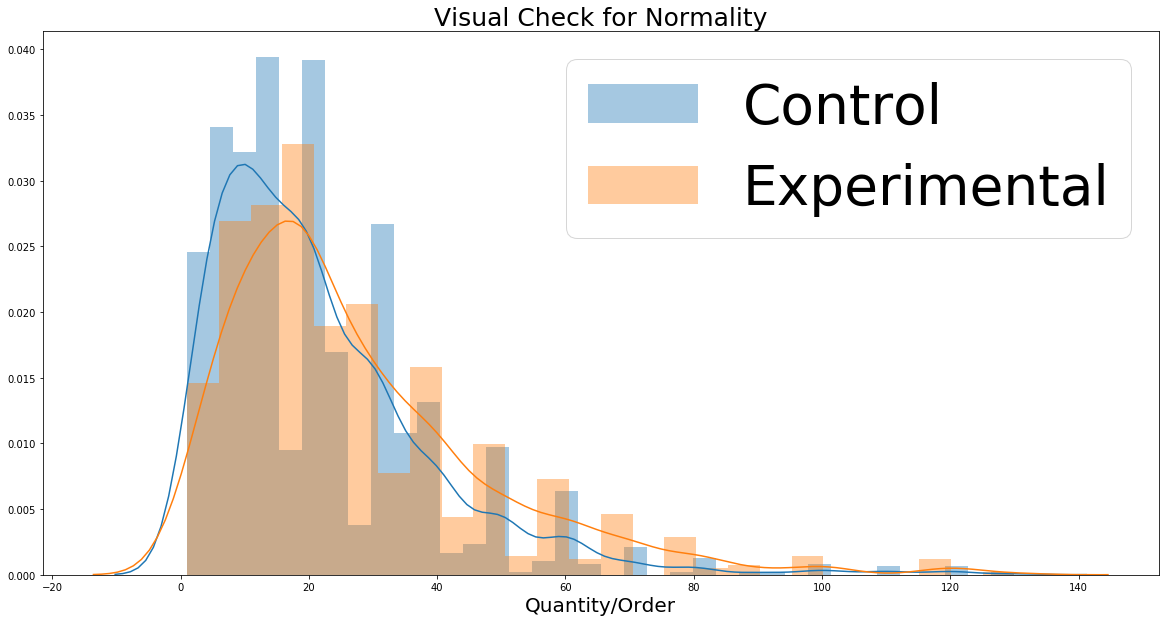

In [17]:
# visual check for normality
plt.figure(figsize=(20, 10))
sns.distplot(ctrl, label='Control')
sns.distplot(exp, label='Experimental',kde=True, hist=True )
plt.title('Visual Check for Normality', fontsize=25)
plt.xlabel('Quantity/Order', fontsize=20)
plt.legend(fontsize=55);

We can see that both the control and test data sets are skewed positive through visual inspection we will now check that observation using scipy's normal test function.

In [18]:
# Use scipy's normal test function for both groups
import scipy.stats as stat

print('Normality of distribution: ', stat.normaltest(ctrl))
print('Normality of distribution: ', stat.normaltest(exp))

Normality of distribution:  NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)
Normality of distribution:  NormaltestResult(statistic=261.04626710761113, pvalue=2.0631145260149106e-57)


statistic = s^2 + k^2 = Skewness + Kurtosis  

In [19]:
stat.skewtest(ctrl) 

SkewtestResult(statistic=19.36939831677361, pvalue=1.3988262245980647e-83)

In [20]:
stat.kurtosistest(ctrl)

KurtosistestResult(statistic=13.015506651733459, pvalue=9.987763752128882e-39)

If the visual was not obvious enough, such a low p-value result from the scipy.stats.normaltest results should remove all doubt.  The resulting distribution is non-normal.  The results of both the experimental and control groups are positively skewed.  We can still use this sample thanks to the [Central Limit Theorem](https://towardsdatascience.com/understanding-the-central-limit-theorem-642473c63ad8). 

#### 2.2.2 Independence

The next assumption is independence both within and between groups. This assumption is satisfied because one order is not related to the other.  If the variables were dependent we would be given some information that the price of an item increases or decreases depending on supply/demand.  Since we are not told this we assume the variables are completely independent satisfying the independence assumption.

#### 2.2.3 Random

The last assumption is that samples are randomly chosen, meaning every observation has an equal chance of being selected. When we create the sampling distribution of sample mean, we will use numpy's [random.choice function](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html) to ensure a random sample is generated.

### 2.3 Creating a Sampling Distribution of Sample Mean

In [22]:
sample = ctrl+exp

In [23]:
len(ctrl)

1317

In [24]:
len(exp)

830

In [25]:
print("control " + str(ctrl.mean()))
print("experimental " + str(exp.mean()))


control 21.715261958997722
experimental 27.35421686746988


In [50]:
original_diff = abs(ctrl.mean()-exp.mean())
original_diff

5.638954908472158

The mean value of experimental group is about 5.6 units greater than the control group. We need to figure out if this is really significant by randomly selecting from an entire population where both groups are together. **Sampling** will reduce the sensitivity to outliers and determine the probability that the larger value within the treatment group is actually just random luck.  We are hoping for a p-value of less than .05 so that we may reject the null hypothesis and take one step closer to recommending that the discounts do increase the amount of units sold.  What percentage of our tests will have a difference greater than 5.4?

In [59]:
#check the amount of samples and use 1/2
i = np.round(len(df_orders)/2,0)
i 

1074.0

In [61]:
sample_a = df_orders["Quantity"].sample(int(i))
sample_b = df_orders.drop(sample_a.index)["Quantity"]

In [60]:
sample_diff = abs(np.mean(sample_a) - np.mean(sample_b))
sample_diff

0.07643993050915299

In [30]:
%%time
my_diffs = []
for i in range(10000):
    sample_a = df_orders["Quantity"].sample(1078)
    sample_b = df_orders.drop(sample_a.index)["Quantity"]
    diff = np.mean(sample_a) - np.mean(sample_b)
    my_diffs.append(diff)

CPU times: user 13.5 s, sys: 62.7 ms, total: 13.6 s
Wall time: 13.7 s


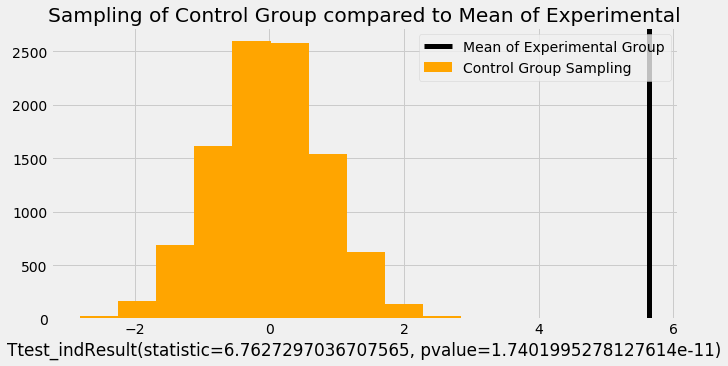

In [65]:
plt.style.use('fivethirtyeight')

fig= plt.figure(figsize=(10,5))

plt.title('Sampling of Control Group compared to Mean of Experimental')

plt.hist(my_diffs, color="orange", label="Control Group Sampling")
plt.axvline(original_diff, color = 'k', linewidth = 5, label="Mean of Experimental Group")
plt.xlabel(ttest_ind(exp.values, ctrl.values ))

plt.legend()
plt.show();
fig.savefig("my_diffs1.png", bbox_inches='tight')


Visually I am convinced that the difference between quantity when a discount is provided vs the control (when there is no discount) is a statistically significant difference.  But I need an actual p-value

In [32]:
my_count = 0
for indv_diff in my_diffs:
    if indv_diff > original_diff:
        my_count += 1

In [33]:
my_count/len(my_diffs)

0.0

## 3 Two Sample t-test

### 3.1 Hypotheses, Type 1 & Type 2 errors


The null and alternative hypotheses are as follows:

$H_o:$ There is no difference in...

$H_a:$ 

We set the significance level ($\alpha$) to 0.05 or 5%. In other words, this is the $\alpha$ value we are comfortable with for making a Type I error which we consider to be more serious than a Type II error. It is important to identify these errors early on so we can improve the test design. With this in mind, what we are trying to do is minimize the probability of committing a Type I error by maximizing the power (probability of making the correct decision when $H_a$ is true). This is one of the reasons why we chose a large sample size.

Type I error: reject 'discount amount has no effect' when it has no effect (i.e. keep offering discounts when it has no effect, resulting in lower revenue)

Type II error: accept 'discount amount has no effect' when it does have an effect (i.e. offer no discounts when it actually has an effect on quantity of product ordered, fail to capture potential revenue)



In [34]:
ttest_ind(exp.values, ctrl.values )

Ttest_indResult(statistic=6.7627297036707565, pvalue=1.7401995278127614e-11)

The very small p-value confirms that there is a statistically significant difference!

In [35]:
# create function to sample with replacement
def get_sample(df, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df)
        sample.append(x)
    return sample

# create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# combine functions to create a sample distribution
# create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
        
    return sample_dist

In [36]:
ctrl_sample = create_sample_distribution(ctrl)
exp_sample = create_sample_distribution(exp)

In [37]:
ttest_ind(exp.values, ctrl.values )

Ttest_indResult(statistic=6.7627297036707565, pvalue=1.7401995278127614e-11)

In [38]:
# Calculate Sample Variance
def variance(sample):
    sample_mean = np.mean(sample)
    return sum([(i - sample_mean)**2 for i in sample])

def sample_variance(sample1, sample2):
    n_1, n_2 = len(sample1), len(sample2)
    var_1, var_2 = variance(sample1), variance(sample2)
    return (var_1 + var_2)/((n_1 + n_2)-2)

In [39]:
# Calculate 2 sample t-statistc
def twosample_tstatistic(exp, ctrl):
    exp_mean, ctrl_mean = np.mean(exp), np.mean(ctrl)
    samp_var = sample_variance(exp, ctrl)
    n_e, n_c = len(exp), len(ctrl)
    num = exp_mean - ctrl_mean
    denom = np.sqrt(samp_var * ((1/n_e)+(1/n_c)))
    return num / denom

t_stat = twosample_tstatistic(exp, ctrl)
t_stat

6.7627297036707565

Given the above information we can calculate area under the curve to find p-value

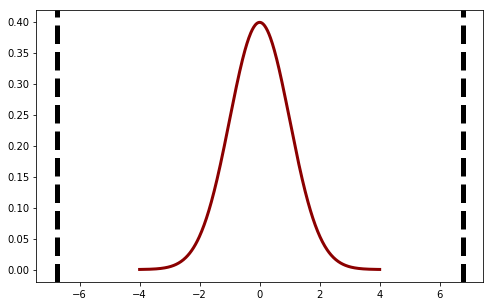

In [40]:
# Visualize test statistic

def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    fig.savefig("tstat1.pdf", bbox_inches='tight')
    
    return None

n_control = len(ctrl_sample)
n_experimental = len(exp_sample)
visualize_t(t_stat, n_control, n_experimental)

### 3.2 Welch's t-test

In [41]:
# create control and experimental groups
# put items without the variable we are curious about into control group
control = df_orders[df_orders['Discount'] == 0]
ctrl = control['Quantity']

# put items with the variable we are curious about into experimental group
experimental = df_orders[df_orders['Discount'] != 0]
treatment= experimental["Quantity"]

In [42]:
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")

welch_ttest(ctrl, treatment)


 Welch's t-test= -6.5112 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 1545.6758


### 3.3 Effect Size

## Cohen's $d$

Cohen’s D is one of the most common ways to measure effect size.  As an effect size, Cohen's d is typically used to represent the magnitude of differences between two (or more) groups on a given variable, with larger values representing a greater differentiation between the two groups on that variable. 

Cohen’s d is similar to the unpaired t test t value. It relies on Standard Deviations instead of Standard Errors

The basic formula to calculate Cohen’s $d$ is:

> ** $d$ = effect size (difference of means) / pooled standard deviation **

The denominator is the **standardiser**, and it is important to select the most appropriate one for a given dataset. The pooled standard deviation is the average spread of all data points around their group mean (not the overall mean). 

In [43]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [44]:
ctrl_sample = np.array(ctrl_sample)
exp_sample = np.array(exp_sample)

The denominator of the equation is the standardiser and, it is important to select the most appropriate standardiser for a given dataset because it can have a big influence on Cohen’s d.

In [45]:
Cohen_d(ctrl_sample,exp_sample)

-6.544252656430226

large effect = 6.33

Parameters I am used to when dealing with Cohen's d

parameters 
small effect = 0 to .2 std 
med. effect = .2 to .8 std 
large effect > .8 std 

*Our Cohen's d value is 6.33; therefore we can categorize the difference as a small to medium effect size.*

### 3.4 One-way ANOVA

In [46]:
df_orders['Quantity'].groupby(df_orders['Discount']).describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0
0.20,161.0,27.024845,18.832801,2.0,12.0,21.0,40.0,100.0
0.25,154.0,28.240260,20.120570,2.0,15.0,25.0,36.0,120.0


In [47]:
# wrap with C() to indicate categorical variable
results = ols('Quantity ~ C(Discount)', data=df_orders).fit()

In [48]:
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)

                    sum_sq      df         F        PR(>F)
C(Discount)   17348.854662     5.0  9.798709  2.840681e-09
Residual     758138.565924  2141.0       NaN           NaN


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    0.05   6.2955   2.0814 10.5097  True 
 0.0    0.1    3.5217  -0.8187  7.8622 False 
 0.0    0.15   6.6669   2.1352 11.1986  True 
 0.0    0.2    5.3096   0.8285  9.7907  True 
 0.0    0.25   6.525    1.954   11.096  True 
 0.05   0.1   -2.7738  -8.4504  2.9028 False 
 0.05   0.15   0.3714  -5.4528  6.1955 False 
 0.05   0.2    -0.986  -6.7708  4.7989 False 
 0.05   0.25   0.2294  -5.6253  6.0842 False 
 0.1    0.15   3.1452   -2.771  9.0613 False 
 0.1    0.2    1.7879  -4.0896  7.6653 False 
 0.1    0.25   3.0033   -2.943  8.9496 False 
 0.15   0.2   -1.3573  -7.3775  4.6628 False 
 0.15   0.25  -0.1419  -6.2292  5.9454 False 
 0.2    0.25   1.2154  -4.8343  7.2652 False 
---------------------------------------------


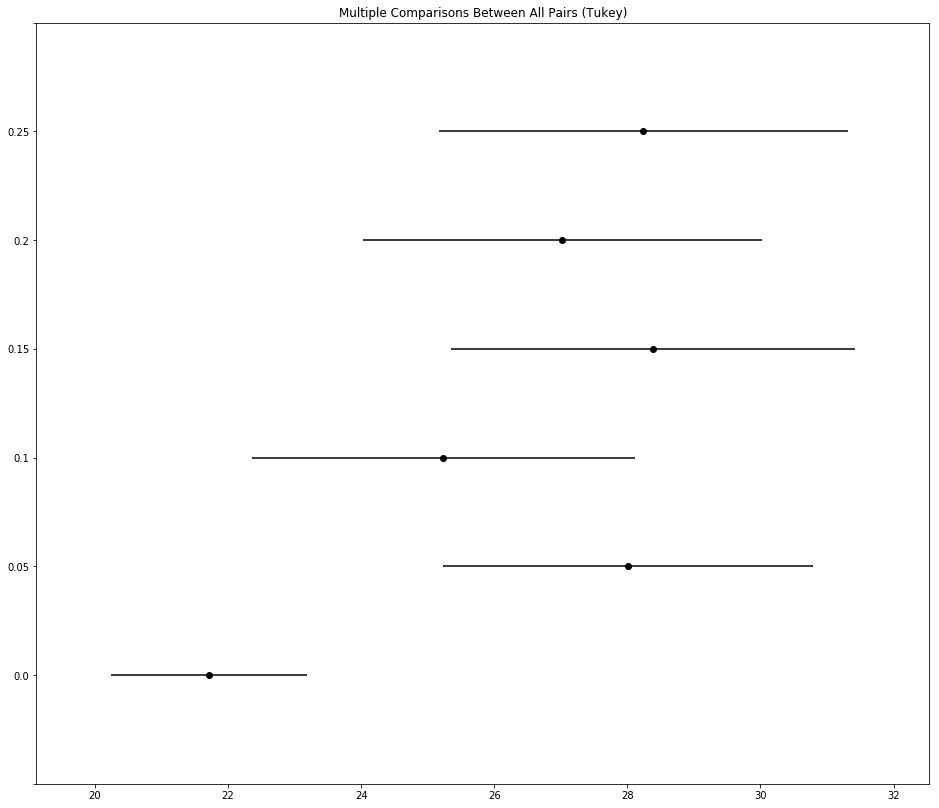

In [49]:
mc = MultiComparison(df_orders['Quantity'], df_orders['Discount'])
mc_results = mc.tukeyhsd()
print(mc_results)

mc_results = mc_results.plot_simultaneous(figsize=(16,14))
plt.show()
mc_results.savefig("mc_results.png", bbox_inches='tight')

The Quantity ordered is significantly larger at 5%, 15%, 20%, and 25% discount levels when the alpha level is set to 0.05

## 4 Additional Hypothesis Tests

### 4.1 [additional question 1](hypothesis2.ipynb)

### 4.2  [additional question 2](hypothesis3.1.ipynb)

### 4.3 [additional question 3](hypothesis4.ipynb)

## 5 Conclusions

We can reject the Null Hypothesis: The number of products customers order is not related to the level of discount.

We can reject the Null Hypothesis that the cost of shipping to each country is roughly the same.

We failed to reject the Null Hypothesis that an order will cost the same regardless of which shipping company is used. 



We can reject the Null Hypothesis that each region spends roughly the same on the average order.